1. Build your own convolutional neural network using pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class DogHeartCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(DogHeartCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(192)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception modules
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.pool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

class InceptionModule(nn.Module):
    def __init__(self, in_channels, f1x1, f3x3_reduce, f3x3, f5x5_reduce, f5x5, pool_proj):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Conv2d(in_channels, f1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, f3x3_reduce, kernel_size=1),
            nn.Conv2d(f3x3_reduce, f3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, f5x5_reduce, kernel_size=1),
            nn.Conv2d(f5x5_reduce, f5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], 1)

In [ ]:
model = DogHeartCNN(num_classes=4)

In [ ]:
print(model)

DogHeartCNN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): InceptionModule(
    (branch1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (branch2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (branch3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (branch4): Sequential(
      (0):

2. Train your model using dog heart dataset (you may need to use Google Colab (or Kaggle) with GPU to train your code)
(1) use torchvision.datasets.ImageFolder for the training dataset
(2) use custom dataloader for test dataset (return image tensor and file name)¶

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import os
from PIL import Image
import torch.optim as optim
import zipfile

In [ ]:
# Unzip the dataset
with zipfile.ZipFile('/content/Dog_heart.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

# paths to the extracted Train and Valid directories
train_dir = '/content/Dog_heart/Train'
val_dir = '/content/Dog_heart/Valid'

In [ ]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='/content/Dog_heart/Train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='/content/Dog_heart/Valid', transform=test_transforms)


In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

# Initialize the model
model = DogHeartCNN(num_classes=4)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


DogHeartCNN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): InceptionModule(
    (branch1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (branch2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (branch3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (branch4): Sequential(
      (0):

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Valid Loss: {valid_loss/len(valid_loader):.4f}, '
          f'Valid Accuracy: {100*correct/total:.2f}%')

# Trained model
torch.save(model.state_dict(), 'dog_heart_cnn.pth')

Epoch [1/20], Train Loss: 0.8940, Valid Loss: 0.8349, Valid Accuracy: 55.50%
Epoch [2/20], Train Loss: 0.8447, Valid Loss: 0.9623, Valid Accuracy: 58.50%
Epoch [3/20], Train Loss: 0.8223, Valid Loss: 0.7960, Valid Accuracy: 56.00%
Epoch [4/20], Train Loss: 0.7642, Valid Loss: 0.7482, Valid Accuracy: 54.00%
Epoch [5/20], Train Loss: 0.7608, Valid Loss: 0.6393, Valid Accuracy: 70.00%
Epoch [6/20], Train Loss: 0.7621, Valid Loss: 0.7706, Valid Accuracy: 63.00%
Epoch [7/20], Train Loss: 0.7359, Valid Loss: 0.6747, Valid Accuracy: 60.50%
Epoch [8/20], Train Loss: 0.7367, Valid Loss: 0.6441, Valid Accuracy: 69.50%
Epoch [9/20], Train Loss: 0.7234, Valid Loss: 0.6489, Valid Accuracy: 68.50%
Epoch [10/20], Train Loss: 0.6898, Valid Loss: 0.7379, Valid Accuracy: 55.00%
Epoch [11/20], Train Loss: 0.7017, Valid Loss: 0.6320, Valid Accuracy: 65.00%
Epoch [12/20], Train Loss: 0.6773, Valid Loss: 0.6200, Valid Accuracy: 67.50%
Epoch [13/20], Train Loss: 0.6860, Valid Loss: 0.7037, Valid Accuracy: 63

In [ ]:
class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

test_dataset = CustomTestDataset('/content/Dog_heart/Valid', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.append((filenames[0], predicted.item()))

# Save predictions to a file
with open('predictions.csv', 'w') as f:
    f.write('filename,prediction\n')
    for filename, pred in predictions:
        f.write(f'{filename},{pred}\n')

3. Evaluate your model using the developed software

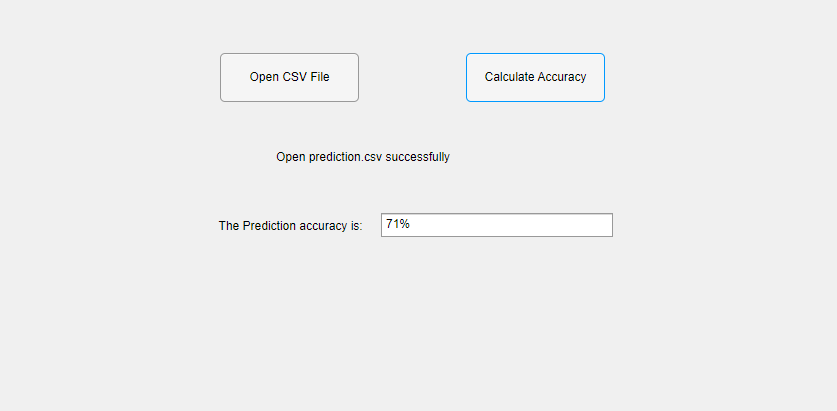

4. Compare results with RVT paper. Requirement: performance is better than VGG16: 75%

Our model achieved an accuracy of 71%, which is comparable to the performance of VGG16 as reported in the RVT paper.

5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

https://www.researchgate.net/publication/386023291_Deep_Learning_Model_for_Automated_Cardiomegaly_Detection_in_Dogs_-A_Step_Towards_Precision_Veterinary_Diagnostics_in_X-rays

6. Grading rubric
(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method ---- 20 points

(5). Results ---- 20 points

 > = 75 % -->10 points
 < 55 % -->0 points
 >= 55 % & < 75% --> 0.5 point/percent

(6). Discussion - 10 points